# Global indicator project - Phoenix, Arizona
## Create frequent stop analysis - with GTFS data


This notebook describes the process to load GTFS files using UrbanAccess (from UrbanSim) and generalises GTFS analysis developed by the Healthy Liveable Cities group in work lead by Jonathan Arundel in 2017 through 2019 for Australian state transit agency GTFS feeds. The scripts in this notebook is built on work of Jonathan Arundel (2017-2018) SQL and Carl Higgs python scripts (2019).  
A handy guide to the format of GTFS fields is [here](https://developers.google.com/transit/gtfs/reference/#tripstxt).


### Process:  
1. Download or load GTFS data into an UrbanAccess transit data frame  
2. Set up GTFS files in SQL databases
3. Create 30min_stops_analysis (SQL functions)
    - Identify stops qualify on a daily basis : First service departs before 7.30am; Last service departs on or after 6.30pm;  
    - Has a maximum inter-departure time less than or equal to 30 minutes    
4. Calendar_setup to filter 30min stops operated more than 90% of normal weekdays (SQL)  
    - Identify feeds start and end dates that that a stop is a 30-minute frequency stop
    - Calculate the number of total normal weekdays during calendar start and end date
    - Calculate the number of weekdays that the frequent stop is in operation
    - Calculate the percentage of weekdays that each frequent stop is in operation, select those with 90%

5. Create frequent transit stop analysis with specified criteria and mode of transit (SQL)



In [76]:
import psycopg2

import sys
import datetime
import itertools
from sqlalchemy import create_engine

#load urbanaccess library
import urbanaccess as ua
from urbanaccess.utils import log
from urbanaccess.config import settings
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.gtfs.gtfsfeeds_dataframe import gtfsfeeds_dfs
from urbanaccess.network import ua_network, load_network



In [77]:
# configure filenames to save/load POI and network datasets
gtfs_folder = '/Volumes/My Passport for Mac/Shirley_MacTranscend/GTFS/data/Transport'

gtfs_url = 'https://www.phoenixopendata.com/dataset/3eae9a4a-98b9-40c8-8df7-8c00c1756235/resource/28ccc0a5-49c8-495c-b91f-193de5ce2cb7/download/googletransit.zip'
gtfs_provider = 'Phx Valley metro'

In [78]:
#Bounding box formatted as a 4 element tuple: (lng_max, lat_min, lng_min, lat_max)
bbox = (-113.3338,32.505,-111.0399,34.0481) #bounding box for Maricopa County

## 1. Download or load GTFS data into an UrbanAccess transit data frame

### Using UrbanAccess as source for:
- The settings object
- The feeds object and searching for GTFS feeds
- Downloading GTFS data
- Loading GTFS data into a UrbanAccess transit data object

For UrbanAccess installation instructions see: https://udst.github.io/urbanaccess/installation.html

Load the GTFS feeds (currently a series of text files stored on disk) into a combined network of Pandas DataFrames.

- You can specify one feed or multiple feeds that are inside a root folder using the `gtfsfeed_path` parameter. If you want to aggregate multiple transit networks together, all the GTFS feeds you want to aggregate must be inside of a single root folder.
- Turn on `validation` and set a bounding box with the `remove_stops_outsidebbox` parameter turned on to ensure all your GTFS feed data are within a specified area.


Phoenix GTFS data from transitfeed.com https://transitfeeds.com/p/valley-metro/68

In [79]:
loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path=gtfs_folder,
                                           validation=True,
                                           bbox=bbox,
                                           remove_stops_outsidebbox=True,
                                           append_definitions=True)

GTFS text file header whitespace check completed. Took 5.99 seconds
--------------------------------
Processing GTFS feed: gtfs
The agency.txt or agency_id column was not found. The unique agency id: gtfs was generated using the name of the folder containing the GTFS feed text files.
Unique agency id operation complete. Took 0.11 seconds
Unique GTFS feed id operation complete. Took 0.02 seconds
Records: {}
     stop_id  stop_code        stop_name  stop_desc   stop_lat    stop_lon  \
7800    9730    17112.0  2nd Av & 5th St        NaN  32.382707 -112.872186   

      zone_id  stop_url  location_type parent_station unique_agency_id  \
7800      NaN       NaN              0            NaN             gtfs   

     unique_feed_id  
7800         gtfs_1  
Removed identified stops that are outside of bounding box.
gtfs GTFS feed stops: coordinates are in northwest hemisphere. Latitude = North (90); Longitude = West (-90).
Appended route type to stops
Appended route type to stop_times
--------

### The transit data object

The output is a global `urbanaccess_gtfs_df` object that can be accessed with the specified variable `loaded_feeds`. This object holds all the individual GTFS feed files aggregated together with each GTFS feed file type in separate Pandas DataFrames to represent all the loaded transit feeds in a metropolitan area. 

In [80]:
#loaded_feeds.stops.head()

Quickly view the transit stop locations

In [81]:
#loaded_feeds.stops.plot(kind='scatter', x='stop_lon', y='stop_lat', s=0.1)

In [82]:
len(loaded_feeds.stops)

7886

## 2. Run public transit frequency analysis with pre-specified SQL file

First, install postgres, postgis, sqlalchemy, and psycopg2. Then create the database from command prompt if it doesn't already exist:

```
createdb -U postgres gtfs_phx_201907
psql -U postgres -d gtfs_phx_201907 -c "CREATE EXTENSION postgis;"
```
More info in the psycopg2 docs: http://initd.org/psycopg/docs/usage.html

This part connect to a postgres database and execute three pre-specified .SQL scripts: 'setup_gtfs_tables.sql'; 'parameterised_mode_freq_functions.sql'; 'frequent_stop_analysis.sql' to set up gtfs tables in the database, create functions for analysis, and analyse for frequent transport.  

Note to work around SQL scripts:
- Input data format, including which tables, which columns, which order and handling of nulls - you'll need to customise this for each city.  
- Work out how stops for a mode can be identified; i.e. by agency_id (e.g. in Melbourne the bus, train and tram modes have different agencies, by route_type.  Update stop_analysis for stop identification.
- Check if train stations are whole stations or platforms with a parent station and modify scripts accordingly.
- For each mode and state check the number of frequent stops by date, sometimes the number will drop off because data is not yet loaded into the timetable, modify the end date accordingly.

### Set up configuration and SQL parameters

In [83]:
# specify required GTFS files
required_gtfs_files = ['agency.txt', 'calendar.txt', 'calendar_dates.txt', 'routes.txt', 
                  'shapes.txt', 'stop_times.txt', 'stops.txt', 'trips.txt'] 

# specify complete path for each file
agency = gtfs_folder + '/' + 'gtfs' + '/' + required_gtfs_files[0]
calendar = gtfs_folder + '/' + 'gtfs' + '/' + required_gtfs_files[1]
calendar_dates = gtfs_folder + '/' + 'gtfs' + '/' + required_gtfs_files[2]
routes = gtfs_folder + '/' + 'gtfs' + '/' + required_gtfs_files[3]
shapes = gtfs_folder + '/' + 'gtfs' + '/' + required_gtfs_files[4] 
stop_times = gtfs_folder + '/' + 'gtfs' + '/' + required_gtfs_files[5]
stops = gtfs_folder + '/' + 'gtfs' +'/' + required_gtfs_files[6]
trips = gtfs_folder + '/' + 'gtfs' + '/' + required_gtfs_files[7]

In [84]:
# define modes for GTFS feed(s) as per agency_id codes in agency.txt below
modes = {
         'rail':{'route_types':[0],'custom_mode':'', 'start_times':['07:00:00'],'end_times':['9:00:00'],'intervals':['00:30:00']},
         'bus'  :{'route_types':[3],'custom_mode':'', 'start_times':['07:00:00'],'end_times':['9:00:00'],'intervals':['00:30:00']}
         }

# define month and day for "representative period" ie. not in school time; here example is July 15 to August 15
# start_date_mmdd = 0715
# end_date_mmdd = 0815
start_date_mmdd = '0403'
end_date_mmdd = '0418'

In [85]:
#open and read SQL files
with open('setup_gtfs_tables.sql', 'r') as myfile:
    setup_sql = myfile.read()

with open('parameterised_mode_freq_functions.sql', 'r') as myfile:
    freq_analysis_function = myfile.read()

with open('frequent_stop_analysis.sql', 'r') as myfile:
    freq_analysis = myfile.read()
 

In [86]:
#specify pgadmin user info
pg_db = 'gtfs_phx_201907'
pg_user = 'postgres'
pg_host = 'localhost'
pg_port = '5432'
pg_pass = '3456799000'

In [87]:
# specify modes parameters
mode = 'bus'

time_format  ='%H:%M:%S'
short_time   = '%H%M'
durations = list(itertools.product(modes[mode]['start_times'], modes[mode]['end_times']))
for duration in durations:
    start_time = duration[0]
    end_time   = duration[1]
    for interval in modes[mode]['intervals']:
        interval  = datetime.datetime.strptime(interval,time_format)
        interval_time  = datetime.timedelta(hours=interval.hour, minutes=interval.minute, seconds=interval.second)
        buffer_start = (datetime.datetime.strptime(start_time, time_format) + interval_time)
        buffer_end   = (datetime.datetime.strptime(end_time, time_format) - interval_time)

In [88]:
#set up SQL with pre-specified modes parameters
setup_gtfs_tables = ''
setup_gtfs_tables = '{}\n{}'.format(setup_gtfs_tables,
                                    setup_sql.format(
                                        agency         = agency,
                                        calendar       = calendar,
                                        calendar_dates = calendar_dates,
                                        routes         = routes,
                                        shapes         = shapes,
                                        stop_times     = stop_times,
                                        stops          = stops,
                                        trips          = trips))
                                        
create_gtfs_analysis_functions = ''
create_gtfs_analysis_functions = '{}\n{}'.format(create_gtfs_analysis_functions,
                                                 freq_analysis_function.format(
                     mode               = mode                                     ,
                     start_time         = start_time                               ,
                     end_time           = end_time                                 ,
                     buffer_start       = buffer_start.strftime(time_format)       ,
                     buffer_end         = buffer_end.strftime(time_format)         ,
                     buffer_start_short = buffer_start.strftime(short_time)        ,
                     buffer_end_short   = buffer_end.strftime(short_time)          ,
                     interval           = interval.strftime(time_format)            ,
                     interval_short     = interval.strftime(short_time)            ,
                     route_types        = ",".join(['{}'.format(x) for x in modes[mode]['route_types']]),
                     custom_mode        = modes[mode]['custom_mode']))


gtfs_analysis = ''
# deriving year, based on assumption suffix is _yyyymmdd
year = 2019
analysis_start_date = '{}{}'.format(year,start_date_mmdd)
analysis_end_date   = '{}{}'.format(year,end_date_mmdd)
gtfs_analysis = '{}\n{}'.format(gtfs_analysis, 
                                freq_analysis.format(
                     mode               = mode                                     ,
                     start_date         = analysis_start_date                      ,
                     end_date           = analysis_end_date                        ,
                     start_time         = start_time                               ,
                     end_time           = end_time                                 ,
                     buffer_start       = buffer_start.strftime(time_format)       ,
                     buffer_end         = buffer_end.strftime(time_format)         ,
                     buffer_start_short = buffer_start.strftime(short_time)        ,
                     buffer_end_short   = buffer_end.strftime(short_time)          ,
                     interval           = interval.strftime(time_format)            ,
                     interval_short     = interval.strftime(short_time)            ,
                     route_types        = ",".join(['{}'.format(x) for x in modes[mode]['route_types']]),
                     custom_mode        = modes[mode]['custom_mode']))
                                                                                           


### execute SQL freqency analysis

In [89]:
# define functions for executing the SQL commend
def execute_ScriptsFromSQL(SQL_analysis):
    # connect to the database
    connection = psycopg2.connect(database=pg_db,
                              user=pg_user,
                              password=pg_pass,
                              host=pg_host,
                              port=pg_port)
    
    cursor = connection.cursor()
    
    
    cursor.execute(SQL_analysis)
    connection.commit()
    connection.close()

In [90]:
# execute the SQL analyses files
execute_ScriptsFromSQL(setup_gtfs_tables)
execute_ScriptsFromSQL(create_gtfs_analysis_functions)
execute_ScriptsFromSQL(gtfs_analysis)

In [91]:
from shapely.geometry import shape,Point, LineString, Polygon
import geopandas as gpd

def get_gdf_fromSQLtable(SQL_tablename):
    engine = create_engine("postgresql://{user}:{pwd}@{host}/{db}".format(user = pg_user,
                                                                      pwd  = pg_pass,
                                                                      host = pg_host,
                                                                      db   = pg_db))
    df = pd.read_sql_table(SQL_tablename, con=engine)
    df['geometry'] = df.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    return gdf


In [92]:
stop_30_mins_bus_final = get_gdf_fromSQLtable('bus_0030_stop_final')
stop_30_mins_bus_final.head()

,route_type,stop_id,stop_name,stop_lat,stop_lon,geometry
0,3,7125,Van Buren St & 21st Av,33.451319,-112.105049,POINT (-112.1050493 33.45131936)
1,3,20011,40th St & Elwood St,33.414488,-111.995519,POINT (-111.9955192 33.41448848)
2,3,9384,40th St & Cholla St,33.589620,-111.995879,POINT (-111.9958789 33.58961953)
3,3,2232,35th Av & Dunlap Av,33.567996,-112.134089,POINT (-112.1340885 33.56799588)
4,3,774,Thomas Rd & Scottsdale Rd,33.480189,-111.925411,POINT (-111.9254112 33.48018926)


In [93]:
stop_30_mins_rail_final = get_gdf_fromSQLtable('rail_0030_stop_final')
stop_30_mins_rail_final.head()

,route_type,stop_id,stop_name,stop_lat,stop_lon,geometry
0,0,9022,Smith-Martin/Apache Blvd,33.414792,-111.900800,POINT (-111.9008 33.414792)
1,0,9043,Mill Ave/3rd St,33.427543,-111.940178,POINT (-111.940178 33.427543)
2,0,9032,3rd St/Washington,33.448360,-112.070662,POINT (-112.070662 33.44836)
3,0,6655,Glendale/19th Ave,33.537453,-112.099685,POINT (-112.099685 33.537453)
4,0,9502,Mesa Dr/Main St,33.415066,-111.822135,POINT (-111.822135 33.415066)


In [ ]:
# save frequent transport dataframe
frequent_busstop_filepath = "../data/Transport/gtfs_phx/stop_30_mins_bus_final.csv"
frequent_railstop_filepath = "../data/Transport/gtfs_phx/stop_30_mins_rail_final.csv"

stop_30_mins_bus_final.to_csv(frequent_busstop_filepath)
stop_30_mins_rail_final.to_csv(frequent_railstop_filepath)


### transit mode freqeuncy analysis

In [95]:
union_tables_by_mode = []
summarise_tables_by_mode = []
from_tables_by_mode = []

for mode in modes:
    text = '''SELECT * FROM {mode}_0030_stop_final'''.format(mode = mode)
    union_tables_by_mode.append(text)
    text = '''
    {mode}_freq, 
    {mode},
    round(100*({mode}_freq /NULLIF({mode}::float,0))::numeric,2) AS {mode}_freq_pct'''.format(mode = mode)
    summarise_tables_by_mode.append(text)
    text = '''
    (SELECT COUNT(*) FROM {mode}_0030_stop_final) AS {mode}_freq,
    (SELECT COUNT(*) FROM stop_{mode}) AS {mode}'''.format(mode = mode)
    from_tables_by_mode.append(text)
    
union_tables_by_mode = '\nUNION ALL\n'.join(union_tables_by_mode)
summarise_tables_by_mode = ','.join(summarise_tables_by_mode)
from_tables_by_mode = ','.join(from_tables_by_mode)

In [96]:
def get_df_fromSQLtables(SQL_tablename):
    engine = create_engine("postgresql://{user}:{pwd}@{host}/{db}".format(user = pg_user,
                                                                      pwd  = pg_pass,
                                                                      host = pg_host,
                                                                      db   = pg_db))
    df = pd.read_sql_table(SQL_tablename, con=engine)

    return df

In [97]:
create_combined_analysis_results = '''
        ------------------------------
        -- Combine 30 minutes stops -- 
        ------------------------------
        DROP TABLE IF EXISTS stop_0030_final;
        CREATE TABLE stop_0030_final AS
        SELECT
          *
        FROM (
          {union_tables_by_mode}
        ) s
        ;
        DROP TABLE IF EXISTS mode_freq_comparison;
        CREATE TABLE mode_freq_comparison AS
        SELECT {summarise_tables_by_mode}
        FROM (SELECT 
              {from_tables_by_mode}
              ) t;
        '''.format(union_tables_by_mode = union_tables_by_mode,
                   summarise_tables_by_mode = summarise_tables_by_mode,
                   from_tables_by_mode = from_tables_by_mode)

execute_ScriptsFromSQL(create_combined_analysis_results)
        
mode_freq_comparison = get_df_fromSQLtables('mode_freq_comparison')
mode_freq_comparison

,rail_freq,rail,rail_freq_pct,bus_freq,bus,bus_freq_pct
0,76,80,95.0,6481,7766,83.45


### plot bus stop and freqent bus stop

In [98]:
all_stops_gdf = get_gdf_fromSQLtable('stops')

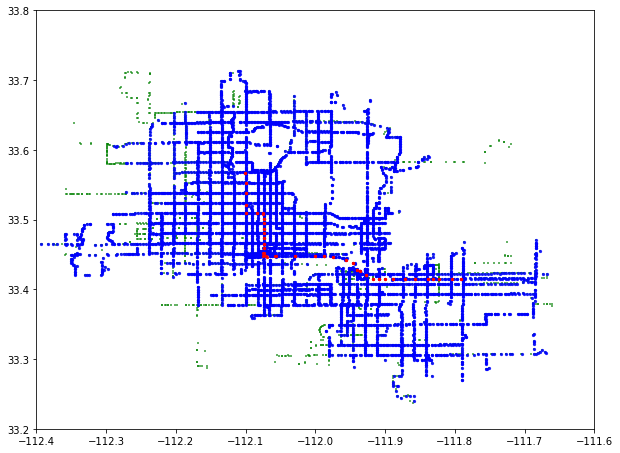

In [99]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 10))
ax = all_stops_gdf.plot(ax=ax, color='green', marker='+', markersize=5, alpha=0.6)
ax = stop_30_mins_bus_final.plot(ax=ax, color='blue', marker='o', markersize=5, alpha=0.8)
ax = stop_30_mins_rail_final.plot(ax=ax, color='red', marker='o', markersize=5, alpha=0.9)
ax.set_xlim(-112.4, -111.6)
ax.set_ylim(33.2, 33.8)
#ax.set_axis_off()

plt.show()